# 1. Install requirements

In [150]:
# !pip install pandas matplotlib datashader bokeh holoviews scikit-image colorcet

In [151]:
# !pip install -U sentence-transformers

In [152]:
# !pip install umap-learn

In [153]:
# !pip install hdbscan

In [154]:
# !pip install bertopic

#Configs

Partimos del dataset con el texto procesado y usamos el modelo que identifica entre +50 lenguajes, dado que nuestro texto se encuentra en portugues.

In [102]:
data_path = "dataset_items_cleaned.csv" #@param {type:"string"}
text_column_name = "text" #@param {type:"string"}
label_column_name = "label" #@param {type:"string"}

model_name = "paraphrase-multilingual-MiniLM-L12-v2" #@param {type:"string"}
num_labels = 3 #@param {type:"number"}

# 2. Read cleaned Dataset

Revisamos que el dataset sea el correcto y transformamos el texto limpio en un array de frases (sentences).

In [114]:
import pandas as pd

In [115]:
df = pd.read_csv(data_path)

In [116]:
df.head()

,text,label_original,label,text_cleaned
0,Azure 24k Gold E Colágeno Anti Envelhecimento ...,MLB-FACIAL_SKIN_CARE_PRODUCTS,0,azure 24k gold e colageno anti envelhecimento ...
1,Avène Dermabsolu Creme Redensificador Com Cor ...,MLB-FACIAL_SKIN_CARE_PRODUCTS,0,avene dermabsolu creme redensificador com cor ...
2,Cr Antirrugas Fps15 45g - Kit C/ 03 Unidades,MLB-FACIAL_SKIN_CARE_PRODUCTS,0,cr antirrugas fps15 45g kit c 03 unidades
3,Kit Com 3 Cuba Rim Plásticas Branca 700ml Este...,MLB-FACIAL_SKIN_CARE_PRODUCTS,0,kit com 3 cuba rim plasticas branca 700ml este...
4,Adcos Collagen Sérum Anti-idade - 30ml,MLB-FACIAL_SKIN_CARE_PRODUCTS,0,adcos collagen serum anti idade 30ml


In [117]:
df.label.value_counts()

0    2000
1    2000
2    2000
Name: label, dtype: int64

In [118]:
sentences = df["text_cleaned"].tolist()

# 3. Initialize and Train Model

Sentence_Transformer es una arquitectura tipo Transformer que embebe el texto(embedding) en vectores, usando la metología BERT. Esto le permite representar de forma espacial la similitud contextual entre las diferentes frases (sentences) que estamos analizando.

Ver: https://www.sbert.net/

In [119]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer(model_name)

In [120]:
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

In [121]:
embeddings

array([[-2.3214263e-01,  4.0933043e-01, -6.3758105e-02, ...,
        -5.7195121e-01,  1.9805759e-01,  1.5202064e-02],
       [ 2.1220833e-02,  1.9274238e-01,  6.7545906e-02, ...,
        -1.6751486e-01,  1.4373635e-01,  2.3623483e-01],
       [-3.5299996e-01,  1.8455893e-01, -1.4261600e-01, ...,
        -1.3628934e-01,  9.4542682e-02,  2.8527141e-01],
       ...,
       [-4.1209373e-01,  1.6027987e-04,  2.8923345e-01, ...,
        -9.6416675e-02, -7.4286185e-02, -1.8224409e-01],
       [-3.0062160e-01,  1.5855920e-01,  4.7806915e-02, ...,
        -2.8297272e-01,  3.6642438e-01,  1.7827317e-01],
       [-9.1648854e-02,  4.9579105e-01, -1.7087243e-01, ...,
        -3.4846619e-01,  2.1345258e-01,  3.5868445e-01]], dtype=float32)

# 5. Evaluate Model

Con los embeddings podemos proyectar en un plano en 2 dimensiones su estructura espacial para hacernos a una idea de la similitud contextual en el texto. Para esto usamos la metodología de UMAP que mantiene la estructura geométrica al momento de la proyección.

Ver: https://umap-learn.readthedocs.io/en/latest/

In [122]:
from umap import UMAP

umap_model = UMAP(n_neighbors=10, n_components=2, min_dist=0.1, metric='cosine', random_state=42)

In [123]:
mapper = umap_model.fit(embeddings)

<Axes: >

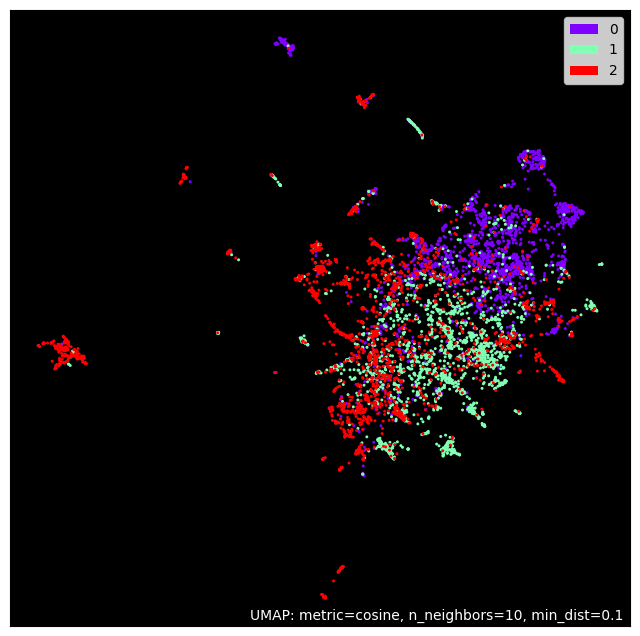

In [124]:
import umap.plot
umap.plot.points(mapper, labels=df.label.to_numpy(), theme='darkgreen')

Contrastando la similitud contextual del texto que describe a los productos con sus respectivas etiquetas (labels) predeterminadas, podemos hacernos a la idea de que a cualquier método de clasificación supervisado de este texto se le dificultará hacer una separación precisa de los productos, basadonse únicamente es su nombre.

Sin embargo, se puede apreciar fácilmente que hay segmentaciones (clusters) bien definidos de productos que se parecen contextualmente entre ellos en su descripción. Por consiguiente, propongo un nuevo ángulo en la siguiente sección.

# 6. A New Proposal

Teniendo en cuenta la visualización contextual de los clusters, podemos realizar una clasificación más detallada de los productos que manejamos, el cuál nos puede ayudar a realizar un análisis más exhaustivo de nuestra oferta.

Usando el método de HDBSCAN para identificar rápidamente estos clusters, se pueden idenficar más etiquetas que ayudan a comprender el espacio de los productos ofertados.

Ver: https://hdbscan.readthedocs.io/en/latest/

In [125]:
clusterable_embedding = umap.UMAP(
    n_neighbors=10,
    min_dist=0.1,
    n_components=2,
    metric='cosine',
    random_state=42,
).fit_transform(embeddings)

In [132]:
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(min_cluster_size=10, cluster_selection_epsilon=0.1) # metric='cosine', cluster_selection_method='eom', prediction_data=True

In [133]:
labels = hdbscan_model.fit_predict(clusterable_embedding)

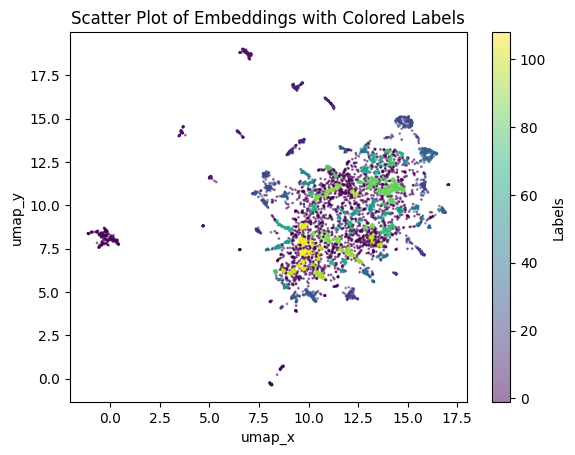

<Figure size 640x480 with 0 Axes>

In [134]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=1, c=labels, cmap='viridis', alpha=0.5)

# Add labels and title
plt.xlabel('umap_x')
plt.ylabel('umap_y')
plt.title('Scatter Plot of Embeddings with Colored Labels')

# Add a colorbar to show label values
cbar = plt.colorbar()
cbar.set_label('Labels')

# Set the background color to black
plt.figure(facecolor='black')

# Show the plot
plt.show()

Una vez identificados los clusters, podemos ir un paso más allá y por medio del método de TF-IDF aplicado a clusters (c-TF-IDF), podemos incluso etiquetar cada cluster por temática (Topic).

Ver: https://github.com/ddangelov/Top2Vec

In [135]:
# Después de varias iteraciones, se identifica que la palabra 'de' se puede interpretar como una stopword y estaba truncando el análisis por temas (topics) de cada cluster.
df_label_by_sentence = pd.DataFrame({'sentence':[x.replace('de ', ' ') for x in sentences], 'label':labels})
print("num_lables:", df_label_by_sentence.label.nunique())

num_lables: 110


In [136]:
df_topic_by_label = df_label_by_sentence.copy().groupby("label")["sentence"].sum()

In [140]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the text data
tfidf_matrix = vectorizer.fit_transform(df_topic_by_label)

# Convert the TF-IDF matrix to a DataFrame for better visualization
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate the TF-IDF DataFrame with the original DataFrame
result_df = pd.DataFrame(df_topic_by_label)

# Extract the top 3 words for each row
top_words = tfidf_df.apply(lambda row: row.nlargest(2).index.tolist(), axis=1)

# Add a new column to the DataFrame with the top 3 words
result_df['top_words'] = ['.'.join(x) for x in top_words]

# Display the result
# print(result_df)

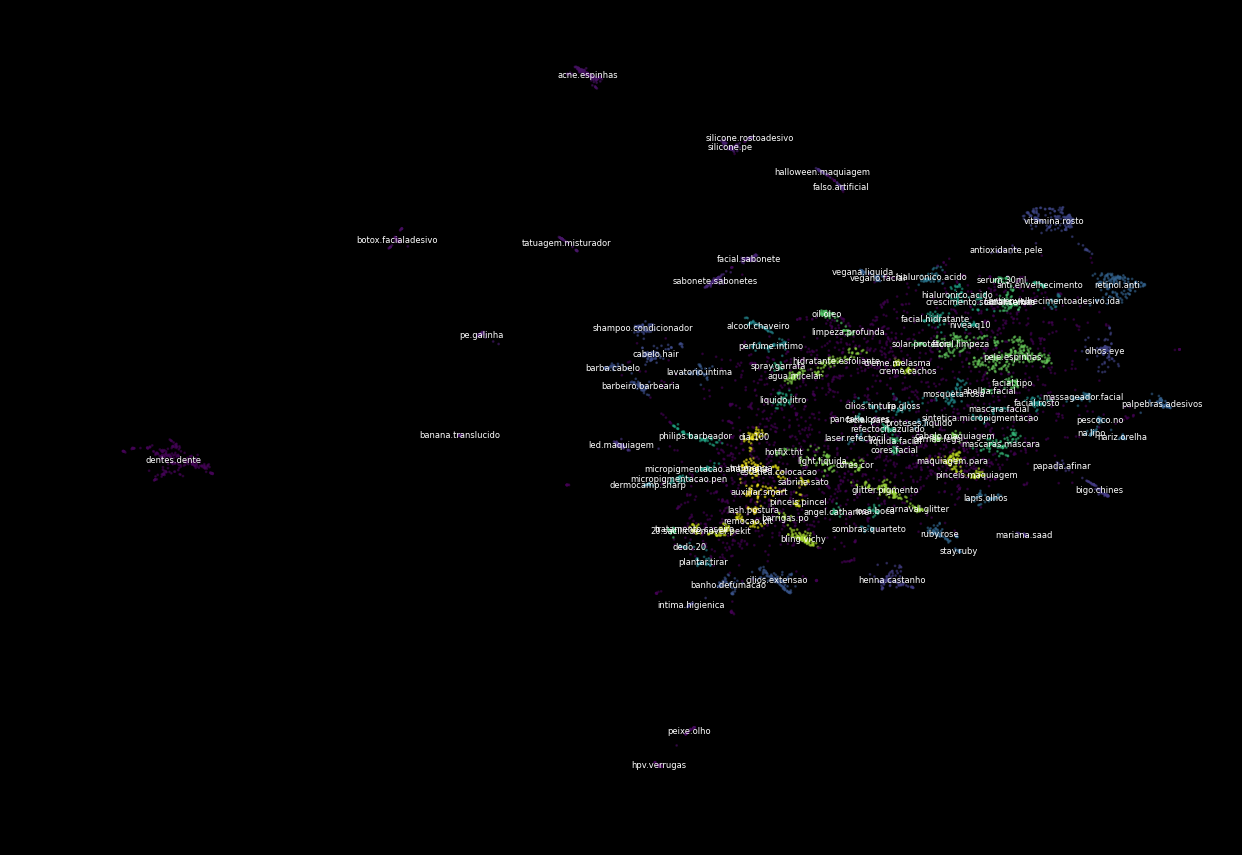

In [146]:
import matplotlib.pyplot as plt

# Set the background color to black
plt.figure(figsize=(15, 10))

# Create a scatter plot
ax = plt.axes()
ax.set_facecolor('black')
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=1, c=labels, cmap='viridis', alpha=0.5)

# Add labels and title
plt.xlabel('umap_x')
plt.ylabel('umap_y')
plt.title('Scatter Plot of Embeddings with Colored Labels')

# # Add a colorbar to show label values
# cbar = plt.colorbar()
# cbar.set_label('Labels')

# Annotate clusters with their corresponding names
for label, word in zip(result_df.index, result_df['top_words']):
    x, y = clusterable_embedding[labels == label].mean(axis=0)
    plt.annotate(word, (x, y), color='white', fontsize=6, ha='center', va='center')

# Show the plot
plt.show()

Observamos una segmentación más rica que nos arroja luces a una oferta que consiste en diferentes productos de belleza, entre estos hay para: los dientes, los ojos, las verrugas, el acné, el cabello y barba, maquillaje, hidrantantes, perfumes, incluso específico para Halloween, entre otros.

# Additional Representations

Se pueden realizar más análisis de los temas y clusters siguiendo el método de BERTopic. A continuación, un primer acercamiento.

Ver: https://github.com/MaartenGr/BERTopic/tree/master

In [147]:
from bertopic import BERTopic
docs = sentences
topic_model = BERTopic(language="multilingual", calculate_probabilities=True, verbose=False)
topics, probs = topic_model.fit_transform(docs)

In [ ]:
# Usar BERTopic para poner nombres a los clusters

In [148]:
topic_model.get_topic_info().head(10).set_index('Topic')[
   ['Count', 'Name', 'Representation']]

,Count,Name,Representation
Topic,,,
-1,1850,-1_maquiagem_de_com_kit,"[maquiagem, de, com, kit, para, facial, creme,..."
0,215,0_dentes_dente_carvao_clarear,"[dentes, dente, carvao, clarear, dental, clare..."
1,135,1_retinol_rey_dr_retinoico,"[retinol, rey, dr, retinoico, rugas, 30, anti,..."
2,114,2_tinta_refectocil_tintura_cores,"[tinta, refectocil, tintura, cores, oxidante, ..."
3,113,3_social_acessorios_filha_vichy,"[social, acessorios, filha, vichy, boticario, ..."
4,109,4_pele_cicatrizes_espinhas_reduz,"[pele, cicatrizes, espinhas, reduz, cicatriza,..."
5,109,5_acne_espinha_espinhas_interna,"[acne, espinha, espinhas, interna, pomada, loc..."
6,98,6_sombras_paleta_cores_iluminador,"[sombras, paleta, cores, iluminador, quarteto,..."
7,87,7_cilios_extensao_alongamento_posticos,"[cilios, extensao, alongamento, posticos, cola..."


In [149]:
topic_model.visualize_barchart(top_n_topics = 10, n_words = 5)